<a href="https://colab.research.google.com/github/saloni1901/Data_science_projects/blob/master/Image_caption_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def readtextfile(path):
    with open(path) as f:
        captions=f.read();
        return captions
    

In [ ]:
!nvidia-smi



Sat Nov  7 04:22:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
captions=readtextfile("/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split("\n")[:-1]

In [ ]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [ ]:
#dictionary to match a image id with its captions

descriptions={}

for x in captions:
    first,second=x.split("\t")
    img_id=first.split('.')[0]
    
    if descriptions.get(img_id) is None:
        descriptions[img_id]=[]
    descriptions[img_id].append(second)

In [ ]:
descriptions["997722733_0cb5439472"]

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string 
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add



In [ ]:
#cleaning text data

def text_clean(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [ ]:
text_clean("A cat, is sitting over the tree")

'cat is sitting over the tree'

In [ ]:
for key,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i]=text_clean(captions_list[i])

In [ ]:
descriptions["997722733_0cb5439472"]

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [ ]:
with open("Descriptions.txt","w") as f:
    f.write(str(descriptions))

In [ ]:
#Vocabulary part
descriptions=None
with open("Descriptions.txt","r") as f:
    descriptions=f.read()

json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)
    


In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
#creating vocab

vocab=set()
for key in descriptions.keys():
    
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [ ]:
print("vocab size:%d"% len(vocab))

vocab size:8424


In [ ]:
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("total word: %d"% len(total_words))

total word: 373837


In [ ]:
#filter most frquent word from the vocab
import collections
counter=collections.Counter(total_words)
freq_count=dict(counter)
print(len(freq_count.keys()))

8424


In [ ]:
#sortin the dictionary

sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x:x[1])
#print(sorted_freq_count)
# filter
thershold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>thershold]
total_words=[x[0] for x in sorted_freq_count]

In [ ]:
print(len(total_words))

1845


In [ ]:
print(total_words)

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'shirt', 'down', 'standing', 'ball', 'little', 'grass', 'snow', 'child', 'person', 'jumping', 'over', 'three', 'front', 'sitting', 'holding', 'up', 'field', 'small', 'by', 'large', 'green', 'one', 'group', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'as', 'bike', 'girls', 'outside', 'other', 'off', 'out', 'rock', 'next', 'play', 'orange', 'looking', 'pink', 'player', 'camera', 'their', 'pool', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'plays', 'stand', 'looks', 'building', 'park', 'cl

In [ ]:
#prepare and train the data
import cv2
train_file_data=readtextfile("/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readtextfile("/content/drive/My Drive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [ ]:
train=[row.split(".")[0] for row in train_file_data.split("\n")][:-1]
test=[row.split(".")[0] for row in test_file_data.split("\n")][:-1]
train[10]

'2851304910_b5721199bc'

In [ ]:
#adding descriptions to images

train_descriptions={}
for imag_id in train:
    train_descriptions[imag_id]=[]
    for cap in descriptions[imag_id]:
        cap_append="start_cap"+ cap +"end_cap"
        train_descriptions[imag_id].append(cap_append)


In [ ]:
train_descriptions["2851304910_b5721199bc"]

['start_capphotographer looks over the hillsend_cap',
 'start_capwoman in red jacket is videotaping natural landscapeend_cap',
 'start_capwoman with camera looks out over rolling hillsend_cap',
 'start_capwoman with camera on tripod is looking at the viewend_cap',
 'start_caplady in red shirt has her camera set up in the field to record somethingend_cap']

In [ ]:
 #Image feature extraction
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()
    
    

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
model_new=Model(model.input,model.layers[-2].output)

In [ ]:
def preprocessing_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
     #Normalizations
    img=preprocess_input(img)
    return img

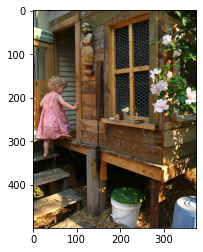

In [ ]:
image1=cv2.imread("/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg")
image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
plt.imshow(image1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

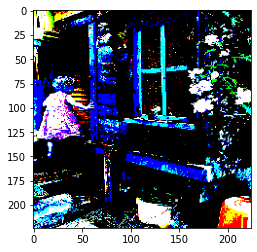

In [ ]:
img=preprocessing_img("/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
print(img)
# here for each pixel we are subtracting pixel means.................

In [ ]:
#encoder

def encoding_image(img):
    img=preprocessing_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encoding_image("/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1000268201_693b08cb0e.jpg")


array([0.06535938, 0.16782546, 0.32517588, ..., 0.05107139, 0.32821164,
       1.0043377 ], dtype=float32)

In [ ]:
#feature vector extracted from RESNET50 module
start=time()
encoding_train={}
#IMG_PATH="/content/drive/My Drive/Flickr_Data/Flickr_Data/Images"
for ix,img_id in enumerate(train):
    img_path="/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/"+img_id+".jpg"
    encoding_train[img_id]=encoding_image(img_path)
    
    if ix%100==0:
        print("encoding is in progress time step %d"%ix)
end=time()

print("toatl time taken :",end-start)
    




encoding is in progress time step 0
encoding is in progress time step 100
encoding is in progress time step 200
encoding is in progress time step 300
encoding is in progress time step 400
encoding is in progress time step 500
encoding is in progress time step 600
encoding is in progress time step 700
encoding is in progress time step 800
encoding is in progress time step 900
encoding is in progress time step 1000
encoding is in progress time step 1100
encoding is in progress time step 1200
encoding is in progress time step 1300
encoding is in progress time step 1400
encoding is in progress time step 1500
encoding is in progress time step 1600
encoding is in progress time step 1700
encoding is in progress time step 1800
encoding is in progress time step 1900
encoding is in progress time step 2000
encoding is in progress time step 2100
encoding is in progress time step 2200
encoding is in progress time step 2300
encoding is in progress time step 2400
encoding is in progress time step 250

In [ ]:
#store evry encoding data in the disk
with open("encoding_train.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start=time()
encoding_test={}
#IMG_PATH="/content/drive/My Drive/Flickr_Data/Flickr_Data/Images"
for ix,img_id in enumerate(test):
    img_path="/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/"+img_id+".jpg"
    encoding_test[img_id]=encoding_image(img_path)
    
    if ix%100==0:
        print("encoding_test is in progress time step %d"%ix)
end=time()

print("toatl time taken by test file :",end-start)
    

encoding_test is in progress time step 0
encoding_test is in progress time step 100
encoding_test is in progress time step 200
encoding_test is in progress time step 300
encoding_test is in progress time step 400
encoding_test is in progress time step 500
encoding_test is in progress time step 600
encoding_test is in progress time step 700
encoding_test is in progress time step 800
encoding_test is in progress time step 900
toatl time taken by test file : 281.7909996509552


In [ ]:
with open("encoding_test.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [ ]:
#captions preprocessing
word_to_indx={}
indx_to_word={}

for i,word in enumerate(total_words):
    word_to_indx[word]=i+1
    indx_to_word[i+1]=word

print(len(total_words))

1845


In [ ]:
#special cshraters to end the sequence
indx_to_word[1846]='startseq'
word_to_indx['startseq']=1846

indx_to_word[1847]='endseq'
word_to_indx['endseq']=1847

vocab_size=len(word_to_indx)+1
print("vocab_size",vocab_size)

vocab_size 1848


In [ ]:
max_length=0;
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_length=max(max_length,len(cap.split()))
        
print(max_length)

33


In [ ]:
#DATA LOADER GENERATOR

def data_generator(train_descriptions,encoding_train,word_to_indx,max_length,batch_size):
    x1,x2,y=[],[],[]
    
    n=0
    while 1:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_indx[word] for word in desc.split() if word in word_to_indx]
                for i in range (1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    ##0 denotes the padding word
                    xi=pad_sequences([xi],maxlen=max_length,value=0,padding="post")[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:

                  #yield[[np.array(x1),np.array(x2)],np.array(y)]
                  yield {"image_input":np.array(x1),"seq_input":np.array(x2)},np.array(y)
                  x1,x2,y=[],[],[]
                  n=0



In [ ]:
#Glove embedding
f=open("/content/drive/My Drive/glove.6B.50d.txt",encoding="utf8")

In [ ]:
embedding_index={}

for line in f:
    values=line.split() 
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    
    

In [ ]:
embedding_index['dog']

array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ])

In [ ]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,ids in word_to_indx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[ids]=embedding_vector
    return matrix

In [ ]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [ ]:
#MODEL ARCHITECTURE
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)


In [ ]:
#captions as input
input_captions=Input(shape=(max_length,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)


In [ ]:
#decoding layer
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)


#combined Model

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f06e78736a0>>

In [ ]:
#EMBEDDING LAYER
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [ ]:
#compilations of the model

model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
#Model Training
epochs=500
batch_size=3
steps=len(train_descriptions)//batch_size




In [ ]:

for i in range(epochs):
  generator=data_generator(train_descriptions,encoding_train,word_to_indx,max_length,batch_size)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('/content/drive/My Drive/model_train'+str(i)+'.h5')
    

 240/2000 [==>...........................] - ETA: 19s - loss: 2.4507

In [ ]:
model=load_model('/content/drive/My Drive/model_train50.h5')

In [ ]:
def predict_captions(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_indx[w] for w in in_text.split() if w in word_to_indx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = indx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption
    
    

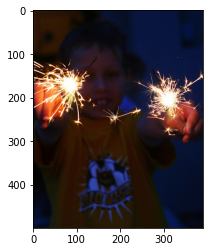

blonde bald ladies are playing pillow in the middle of music and embrace the others are taking picture of the ground all the other watch the photographer in the middle of the


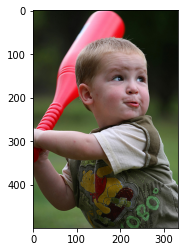

spiderman in the air preparing to the child in the red shirt is holding onto the hand of the green and blue striped shirt on her head and flowers cast in the


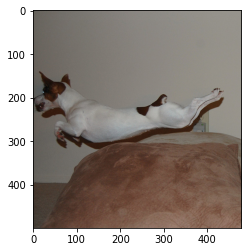

bags is attached to bed to get its frisbee in its mouth sticking out on the edge of the wooden cut the someone is raising his feet on the flat of the


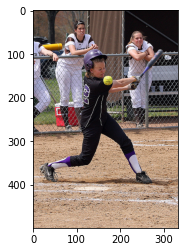

baseball bat goes up to throw the ball with his racquet in the tennis ball in the tennis racket the ball on the other his looks down at the tennis racket and


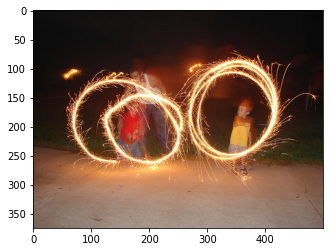

is leaving on the ground and its thumbs spread to the sun and smoke fly comes its can on the hood of the larger store that has spinning around its back of


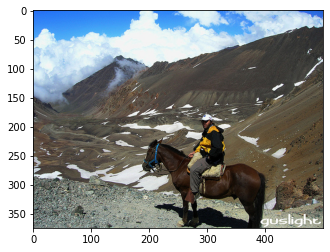

his bike on rocky trail with mountains in the background as the others looks at the sun around the mountains and the others of the other of the other of the other


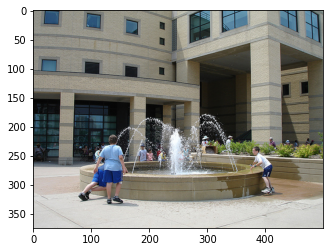

young boy ride scooter down the street in front of the open of the open of the open of the subway and one of the dogs are passing towards the white and


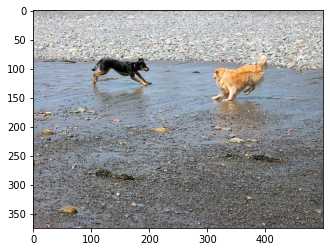

german shepherd approaching the water with stick in its mouth while another dog runs along the water alongside it fly close the swimming in the middle of the green and red is


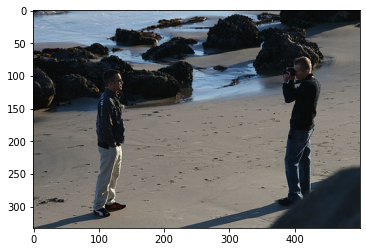

fishing pole in the middle of the ocean is using his hands on the top of the green and black dog is also the lady in the green shirt is sitting on


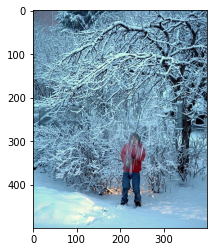

fishing pole in the middle of the stream holding thumbs in his hand and fishing cast in the sun and the sun cast in the sun and the sun cast in the


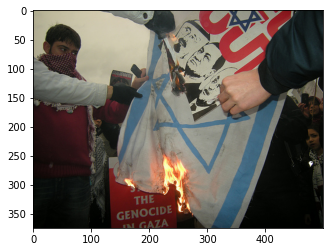

waves in the midst of the ice hockey game with his hands on the left of the woman in the red is sitting on the left of the others in the corner


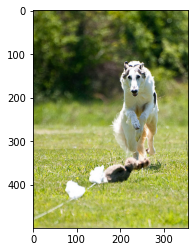

bird in the dry preparing to catch tennis ball in its mouth running in the grassy field with his tongue hanging open and mouth open and tongue hanging out in the mouth


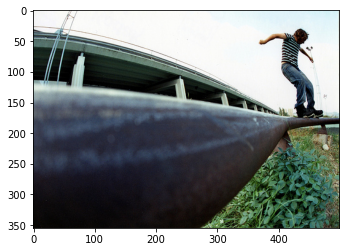

little boy goes down the ramp on his board in the urban and the water on the sand and the the muddy and the other in the air while another man watches


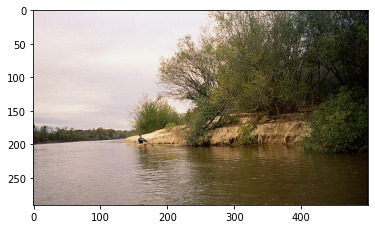

action in the air over flight handle in the ocean with no shirt in the middle of the stream is the sun coming to be seen off of the bank of the


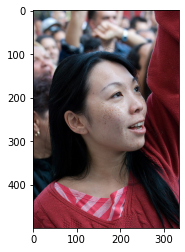

haired woman wearing blue shirt and sunglasses on her head and she looks at the camera while sitting on the ground near the body of the dogs and one is wearing black


In [ ]:
for i in range(15):
  num=np.random.randint(0,1000)
  all_img_name=list(encoding_test.keys())
  img_name=all_img_name[num]
  photo_2048=encoding_test[img_name].reshape((1,2048))
  i=plt.imread("/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
  caption=predict_captions(photo_2048)
  plt.imshow(i)
  plt.show()
  print(caption)
 

In [ ]:

encoding_test["3442242092_e579538d82"].shape

(2048,)